In [1]:
from keras.models import  load_model
from keras.utils import np_utils
import glob
import numpy as np
import os
import sed_eval
import dcase_util
import pickle
#%run shared_functions.ipynb

from PIL import Image

Using TensorFlow backend.


In [2]:

def getStackFeatMat(scene):
    with open(scene, "rb" ) as scenesample:
        l,fv = pickle.load(scenesample)
    return fv,l

def reduceLabels(labels):
    r,c=labels.shape 
    npOfLabels=np.zeros(c)
    for j in range(0,c):
        if np.sum(labels[:,j])>0:
            npOfLabels[j]=1
    return npOfLabels


def fileLists():
    trainlist=[]
    validationlist=[]
    testlist=[]
    evalSetupFiles='..\\..\\CASAdatasets\\DCASE18_ASCT1\\TUT-urban-acoustic-scenes-2018-development\\evaluation_setup\\*.txt'
    txtfilelist=glob.glob(evalSetupFiles)
    for txt in txtfilelist:
        if '_location' not in txt:
            continue
        if 'train' in txt:
            continue
        with open(txt,'r') as evaltxtfile:
            for line in evaltxtfile.readlines():
                line=line.strip().split('\t')[0]
                if 'train' in txt:
                    trainlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
                elif 'test' in txt:
                    testlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
                else:
                    validationlist.append(line.replace('audio','logMelSpec').replace('.wav','_aggScenes.pckl').replace('/','\\'))
    print('validationfiles: ', str(len(validationlist)))
    print('testfiles: ', str(len(testlist)))
    return validationlist,testlist

labelRef={'airport':0,'shopping_mall':1,'metro_station':2,'street_pedestrian':3,'public_square':4,'street_traffic':5,'tram':6,'bus':7,'metro':8,'park':9}
labelRef={'inside':0, 'outside':1, 'transport':2}
nb_classes=len(labelRef.keys())
def getData(flist):
    pth='..\\..\\CASAdatasets\\DCASE18_ASCT1\\TUT-urban-acoustic-scenes-2018-development\\'
    X_=np.zeros(((len(flist)),128,431))
    Y_=np.zeros(((len(flist)),nb_classes))
    for i,tfile in enumerate(flist):
        with open(pth+tfile, "rb" ) as scenesample:
            fv=pickle.load(scenesample)
        X_[i,:,:]=fv
        location=tfile.split('-')[0].replace('logMelSpec\\','')
        if location in ['airport','shopping_mall','metro_station']:
            location='inside'
        elif location in ['street_pedestrian','public_square','street_traffic','park']:
            location='outside'
        else:
            location='transport'
        Y_[i,labelRef[location]]=1
    return X_, Y_
validationlist,testlist=fileLists()
X_v, Y_val = getData(validationlist)
X_te, Y_test = getData(testlist)
print('data obtained')
X_val=np.expand_dims(X_v,axis=3)
X_test=np.expand_dims(X_te,axis=3)

validationfiles:  2518
testfiles:  2518
data obtained


In [5]:
path='models\\3groupedScenes.hdf5'
model=load_model(path)
nb_classes=3
evaluation=model.evaluate(X_test, Y_test, verbose=0,batch_size=16)


In [6]:
print(model.metrics_names)
print(evaluation)

['loss', 'acc']
[0.36594631632318758, 0.8776806989674345]


In [7]:
#evaluate performance of each model
path='models\\3groupedScenes.hdf5'
model=load_model(path)
nb_classes=3
predictions=np.zeros((Y_test.shape))
print(predictions.shape)
print('**')
predictions=model.predict(X_test, verbose=0, batch_size=16) #
#asc(predictions,'test')
print("FIIIINESSSHED :-D")

(2518, 3)
**
FIIIINESSSHED :-D


[[ 636.  109.   58.]
 [  64.  881.    6.]
 [  36.   35.  693.]]
FIIIINESSSHED :-D


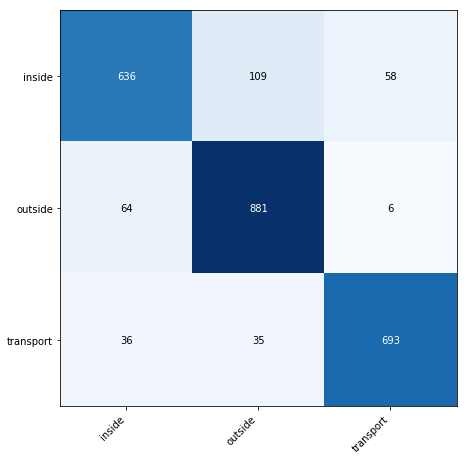

In [10]:
cmat=np.zeros((3,3))
for i, gt in enumerate(Y_test):
    classPred = np.where(predictions[i,:] == max(predictions[i,:]))
    classgt=np.where(gt==max(gt))
    cmat[classgt,classPred]=cmat[classgt,classPred]+1
print(cmat)
plot_confusion_matrix(cmat, labelRef.keys(),output='grouped_scenes.pdf')
print("FIIIINESSSHED :-D")

In [4]:
def hv(preds):
    scene=[]
    s,r=preds.shape
    hv=np.zeros((s,r))
    for i in range(0,s):
        for j in range(0,r):
             if preds[i,j]>globalthreshold:
                hv[i,j]=1
    return hv

print(predictions.shape)
globalthreshold=0.2
test_scenes=hv(predictions)
print(test_scenes.shape)
print(sum(test_scenes))

def asc(scene,evaluate):
    correct=0  
    for idx,s in enumerate(scene):
        match=False
        if sum(s)>1:
            print('WARNING:')
            print(s)
        for j,element in enumerate(s):
            if element==Y_test[idx][j] and element==1:
                match=True
        if match:
            correct=correct+1
    
    print('*** ASC:')
    print('correct scenes: ' +str(correct)+ '\n Accuracy:')
    print(correct/len(Y_test)) 
    return correct/len(Y_test)

acc=asc(test_scenes,'test')

NameError: name 'predictions' is not defined

In [9]:
import itertools
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from matplotlib.patches import Rectangle

def plot_confusion_matrix(mat, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          output = None):
    
    size = 3.5 + len(classes) * 0.5
    plt.figure(figsize=(6.5, 6.5)) 
    plt.imshow(mat, interpolation='nearest', cmap=cmap)
    #plt.title(title)
   # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, horizontalalignment='right')
    plt.yticks(tick_marks, classes)

    fmt = '.0f' 
    thresh = mat.max() / 2.
    for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
        plt.text(j, i, format(mat[i, j], fmt),
                 horizontalalignment="center", verticalalignment="center",
                 color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    #plt.ylabel('True label')
    #plt.xlabel('Predicted label')
    
    if output is not None:
        plt.savefig(output, bbox_inches='tight')
        
#strip out non-supermarket events

#scene_mat=np.random.randint(9, size=(6, 6)) #need actual class values for this!
#classes=[labelRef.keys()]
#plot_confusion_matrix(scene_mat, classes, title='', output='scenes.pdf')
